# LAB Assignment 5.1 - Univariate Time Series using LSTM

**Objective -** To forecast future values of a univariate time series using LSTM-based models

**Name -** Vedant Pawar

**PRN -** 202201040094

**GROUP -** Sarthak Dumbare (202201040038), Darshan Ramagade (202201070044)

**Dataset Link -** https://www.kaggle.com/datasets/anirudhchauhan/retail-store-inventory-forecasting-dataset?resource=download


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [ ]:
np.random.seed(42)

In [ ]:
# Load dataset
df = pd.read_csv('/content/retail_store_inventory.csv')

# Display the basic information
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73100 entries, 0 to 73099
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Date                73100 non-null  object 
 1   Store ID            73100 non-null  object 
 2   Product ID          73100 non-null  object 
 3   Category            73100 non-null  object 
 4   Region              73100 non-null  object 
 5   Inventory Level     73100 non-null  int64  
 6   Units Sold          73100 non-null  int64  
 7   Units Ordered       73100 non-null  int64  
 8   Demand Forecast     73100 non-null  float64
 9   Price               73100 non-null  float64
 10  Discount            73100 non-null  int64  
 11  Weather Condition   73100 non-null  object 
 12  Holiday/Promotion   73100 non-null  int64  
 13  Competitor Pricing  73100 non-null  float64
 14  Seasonality         73100 non-null  object 
dtypes: float64(3), int64(5), object(7)
memory usage: 8.4+

In [ ]:
df.head(10)

,Date,Store ID,Product ID,Category,Region,Inventory Level,Units Sold,Units Ordered,Demand Forecast,Price,Discount,Weather Condition,Holiday/Promotion,Competitor Pricing,Seasonality
0,2022-01-01,S001,P0001,Groceries,North,231,127,55,135.47,33.50,20,Rainy,0,29.69,Autumn
1,2022-01-01,S001,P0002,Toys,South,204,150,66,144.04,63.01,20,Sunny,0,66.16,Autumn
2,2022-01-01,S001,P0003,Toys,West,102,65,51,74.02,27.99,10,Sunny,1,31.32,Summer
3,2022-01-01,S001,P0004,Toys,North,469,61,164,62.18,32.72,10,Cloudy,1,34.74,Autumn
4,2022-01-01,S001,P0005,Electronics,East,166,14,135,9.26,73.64,0,Sunny,0,68.95,Summer
5,2022-01-01,S001,P0006,Groceries,South,138,128,102,139.82,76.83,10,Sunny,1,79.35,Winter
6,2022-01-01,S001,P0007,Furniture,East,359,97,167,108.92,34.16,10,Rainy,1,36.55,Winter
7,2022-01-01,S001,P0008,Clothing,North,380,312,54,329.73,97.99,5,Cloudy,0,100.09,Spring
8,2022-01-01,S001,P0009,Electronics,West,183,175,135,174.15,20.74,10,Cloudy,0,17.66,Autumn
9,2022-01-01,S001,P0010,Toys,South,108,28,196,24.47,59.99,0,Rainy,1,61.21,Winter


In [ ]:
# Filter for a single store and product
store_id = "S001"
product_id = "P0001"

df_filtered = df[(df['Store ID'] == store_id) & (df['Product ID'] == product_id)].copy()

# Convert date, sort and clean
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered.sort_values(by='Date', inplace=True)
df_filtered.dropna(inplace=True)

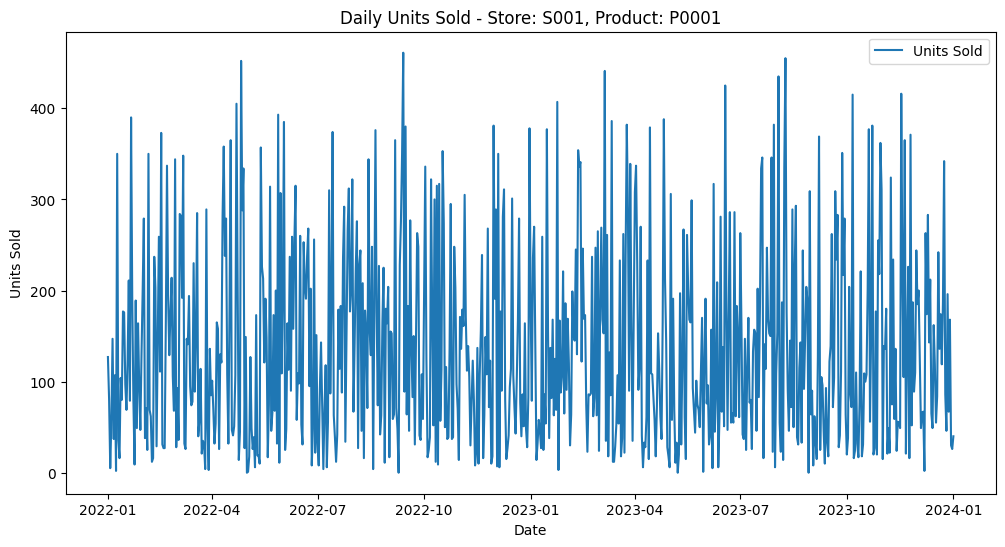

In [ ]:
# Prepare time series
time_series = df_filtered[['Date', 'Units Sold']].copy()
time_series.set_index('Date', inplace=True)

# Plot
plt.figure(figsize=(12,6))
plt.plot(time_series.index, time_series['Units Sold'], label='Units Sold')
plt.xlabel('Date')
plt.ylabel('Units Sold')
plt.title(f'Daily Units Sold - Store: {store_id}, Product: {product_id}')
plt.legend()
plt.show()

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(time_series)

scaled_data[:5]

array([[0.27548807],
       [0.17570499],
       [0.01084599],
       [0.12581345],
       [0.31887202]])

In [ ]:
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

sequence_length = 30  # 1 month of history
X, y = create_sequences(scaled_data, sequence_length)

X = X.reshape(X.shape[0], X.shape[1], 1)

In [ ]:
split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

print(f'Train shape: {X_train.shape}, Test shape: {X_test.shape}')

Train shape: (560, 30, 1), Test shape: (141, 30, 1)


In [ ]:
model = Sequential()
model.add(Bidirectional(LSTM(64, return_sequences=True), input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(64)))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5)
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 30, 128)        │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 30, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,737 (518.50 KB)

 Trainable params: 132,737 (518.50 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(
    X_train, y_train,
    epochs=20,
    batch_size=32,
    validation_data=(X_test, y_test),
    callbacks=[early_stop, checkpoint]
)

Epoch 1/20
17/18 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0852

18/18 ━━━━━━━━━━━━━━━━━━━━ 10s 113ms/step - loss: 0.0835 - val_loss: 0.0547
Epoch 2/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step - loss: 0.0579 - val_loss: 0.0550
Epoch 3/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 0.0623 - val_loss: 0.0549
Epoch 4/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step - loss: 0.0572 - val_loss: 0.0570
Epoch 5/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0555 - val_loss: 0.0564
Epoch 6/20
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0564 - val_loss: 0.0583


In [ ]:
model.load_weights('best_model.h5')

predicted = model.predict(X_test)
predicted_values = scaler.inverse_transform(predicted)
actual_values = scaler.inverse_transform(y_test.reshape(-1, 1))

5/5 ━━━━━━━━━━━━━━━━━━━━ 3s 354ms/step


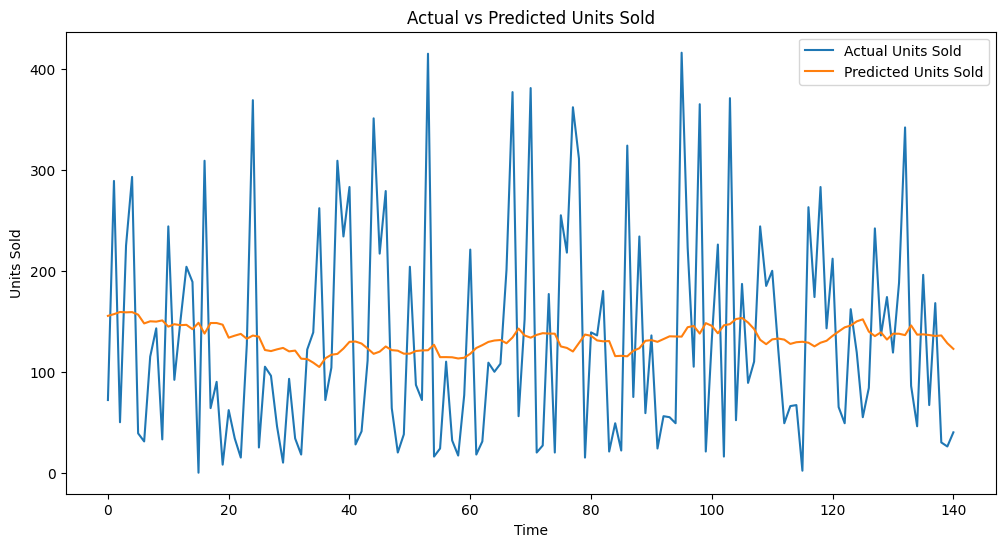

In [ ]:
plt.figure(figsize=(12,6))
plt.plot(actual_values, label='Actual Units Sold')
plt.plot(predicted_values, label='Predicted Units Sold')
plt.title('Actual vs Predicted Units Sold')
plt.xlabel('Time')
plt.ylabel('Units Sold')
plt.legend()
plt.show()


In [ ]:
rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
mae = mean_absolute_error(actual_values, predicted_values)

print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')
print(f'Mean Absolute Error (MAE): {mae:.2f}')

Root Mean Squared Error (RMSE): 107.85
Mean Absolute Error (MAE): 88.95


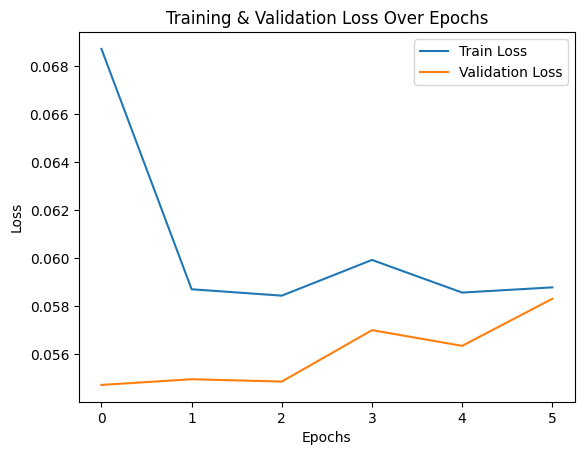

In [ ]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training & Validation Loss Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()